In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

from seffaflik.elektrik import santraller, tuketim, uretim, yekdem

In [3]:
# get Turkey's energy production dataset from epias
start_date = '2020-01-01'
end_date = '2021-01-01'
production = uretim.gerceklesen(start_date, end_date,)

In [4]:
production.head(4)

,Tarih,Saat,Doğalgaz,Barajlı,Linyit,Akarsu,İthal Kömür,Rüzgar,Güneş,Fuel Oil,Jeo Termal,Asfaltit Kömür,Taş Kömür,Biyokütle,Nafta,LNG,Uluslararası,Toplam
0,2020-01-01,0,6166.40,3761.62,5780.09,1545.26,7302.54,770.50,0.0,35.5,1157.82,293.65,572.31,396.65,0,0,278.0,28060.34
1,2020-01-01,1,5161.03,3079.97,5792.66,1548.51,7286.46,776.18,0.0,35.8,1164.57,273.78,575.65,392.46,0,0,394.0,26481.07
2,2020-01-01,2,5149.52,2160.79,5755.22,1460.39,7281.67,787.75,0.0,36.3,1167.74,273.78,585.67,390.22,0,0,172.0,25221.05
3,2020-01-01,3,3860.16,2292.47,5793.94,1591.92,7299.57,815.19,0.0,36.6,1168.91,271.57,569.56,392.99,0,0,154.0,24246.88


In [5]:
production.describe()

,Saat,Doğalgaz,Barajlı,Linyit,Akarsu,İthal Kömür,Rüzgar,Güneş,Fuel Oil,Jeo Termal,Asfaltit Kömür,Taş Kömür,Biyokütle,Nafta,LNG,Uluslararası,Toplam
count,8808.00000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.0,8808.0,8808.000000,8808.000000
mean,11.50000,7746.026504,6515.794933,4303.827785,2331.419566,7111.608642,2788.028970,47.980268,35.631681,1061.087693,252.972661,431.470344,463.165296,0.0,0.0,-62.418569,33026.595775
std,6.92258,3952.323549,3171.403680,622.512318,1448.579504,1716.678584,1608.350955,66.317553,3.309019,105.220071,79.484606,158.347459,36.506329,0.0,0.0,315.830842,5495.008940
min,0.00000,496.660000,366.190000,2189.100000,419.440000,992.650000,139.760000,0.000000,0.000000,663.530000,48.570000,167.240000,369.680000,0.0,0.0,-1949.250000,15246.640000
25%,5.75000,3980.625000,3902.125000,3921.495000,1090.195000,6708.195000,1370.720000,0.000000,34.200000,993.385000,211.960000,272.177500,439.615000,0.0,0.0,-313.360000,29067.472500
50%,11.50000,8929.805000,6796.245000,4305.005000,1809.795000,7656.220000,2588.285000,2.670000,36.400000,1089.000000,242.880000,438.840000,458.440000,0.0,0.0,-85.000000,32908.105000
75%,17.25000,11058.337500,9052.125000,4732.692500,3552.550000,8340.122500,4092.695000,93.282500,37.800000,1141.867500,333.390000,598.862500,480.445000,0.0,0.0,182.000000,37484.857500
max,23.00000,14615.630000,15891.780000,6149.070000,5744.500000,8790.980000,6861.040000,297.990000,43.600000,1255.580000,362.100000,692.620000,596.090000,0.0,0.0,789.000000,45210.030000


we are going to calculate if the average total production will be exceeded with given Natural gas variable. 
If exceeded the probability is 1, if not exceeded it is 0. Let's arrange the data as such.

In [25]:
production_log = production[['Doğalgaz', 'Toplam']].copy(deep=True)

In [26]:
toplam_mean = production_log['Toplam'].mean()

In [27]:
production_log['Toplam'] = production_log['Toplam'].where(production_log['Toplam']<toplam_mean, 1)
production_log['Toplam'] = production_log['Toplam'].where(production_log['Toplam']==1, 0)

In [29]:
production_log['Toplam'].value_counts()

0.0    4455
1.0    4353
Name: Toplam, dtype: int64

if you have unbalanced data use this:

from imblearn.over_sampling import SMOTE

In [30]:
production_log.head(4)

,Doğalgaz,Toplam
0,6166.40,0.0
1,5161.03,0.0
2,5149.52,0.0
3,3860.16,0.0


In [39]:
X = production_log['Doğalgaz'].copy(deep=True).values.reshape(-1, 1)
y = production_log['Toplam'].copy(deep=True).values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [106]:
# normalize train and test X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
# train the model
# liblinear does not work without regularization, so here it is l2 reg.
# C is the regularization strength, larger = weaker regul.
model = LogisticRegression(solver='liblinear', penalty='l2', C = 1.0, random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [109]:
model.classes_

array([0., 1.])

In [110]:
model.intercept_

array([-0.13374842])

In [111]:
model.coef_

array([[1.53620462]])

In [112]:
model.predict_proba(X_train)

array([[0.18392387, 0.81607613],
       [0.80097736, 0.19902264],
       [0.21131019, 0.78868981],
       ...,
       [0.37239111, 0.62760889],
       [0.86525934, 0.13474066],
       [0.92114797, 0.07885203]])

In [113]:
model.score(X_train, y_train)

0.7496451887595799

In [114]:
confusion_matrix(y_train, model.predict(X_train))

array([[2463, 1113],
       [ 651, 2819]])

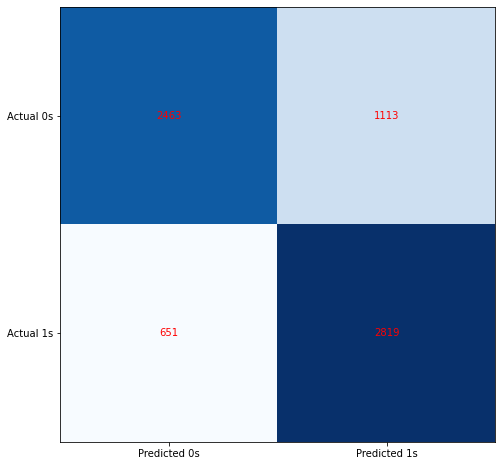

In [115]:
cm = confusion_matrix(y_train, model.predict(X_train))

fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)

ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))

ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [116]:
# train
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.79      0.69      0.74      3576
         1.0       0.72      0.81      0.76      3470

    accuracy                           0.75      7046
   macro avg       0.75      0.75      0.75      7046
weighted avg       0.75      0.75      0.75      7046



In [117]:
y_pred = model.predict(X_test)

In [118]:
# test
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72       879
         1.0       0.71      0.79      0.75       883

    accuracy                           0.73      1762
   macro avg       0.74      0.73      0.73      1762
weighted avg       0.74      0.73      0.73      1762



In [121]:
# roc curve calculation
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

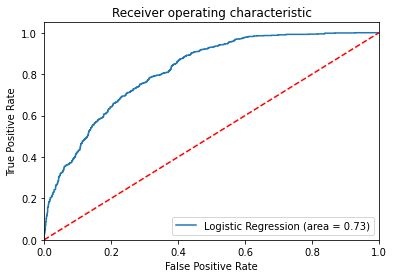

In [123]:
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()